In [ ]:
# how is backtrader

# tutorial
* https://www.heywhale.com/mw/project/63857587d0329ee911dcd7f2 中文
* https://blog.csdn.net/bq_cui/article/details/122884866 一个完整的例子：改写通达信里策略。
* https://blog.csdn.net/qq_41578115/article/details/122529156 系列文章

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
%matplotlib inline

cerebro = bt.Cerebro()

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


# Datafeed in details

* YahooFinanceCSVData

```
    params = (
        ('reverse', False),
        ('adjclose', True),
        ('adjvolume', True),
        ('round', True),
        ('decimals', 2),
        ('roundvolume', False),
        ('swapcloses', False),
    )
```
* 交易数据（Data Feeds）、技术指标（Indicators）和策略（Strategies）都是折线（Line）。 折线（Line）是由一系列的点组成的。  
* 通常交易数据（Data Feeds）包含以下几个组成部分： 开盘价（ Open）、最高价（High）、最低价（Low）、收盘价（Close）、成交量（Volume）、持仓量（OpenInterest）等。 比如：所有的开盘价（ Open）按时间组成一条折线（Line），那么一组交易数据（Data Feeds）就 应该包含了6条折线（Line）。
* datas[0].close数据类型： LineBuffer： LineBuffer defines an interface to an "array.array" (or list) in which index 0 points to the item which is active for input and output.
* 再加上时间（DateTime）一共有7条折线（Line）。时间，一般用作一组交易数据的主键。 

In [2]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

modpath = os.path.dirname(os.path.abspath("./"))
datapath = os.path.join(modpath, 'orcl-1995-2014.txt')
# Create a Data Feed

data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values after this date
    todate=datetime.datetime(2000, 12, 31),
    reverse=False)

In [3]:
print(type(data), len(data))
datapath = './orcl-1995-2014.txt'

<class 'backtrader.feeds.yahoo.YahooFinanceCSVData'> 0


In [4]:
import datetime # 
import os.path # 路径管理  
import sys # 获取当前运行脚本的路径 (in argv[0]) 
#导入backtrader框架  
import backtrader as bt 
# 创建策略继承bt.Strategy 
class TestStrategy(bt.Strategy): 
    params = ( 
    # 均线参数设置15天，15日均线  
    ('maperiod', 15), 
    )
    def log(self, txt, dt=None): 
        # 记录策略的执行日志  
        dt = dt or self.datas[0].datetime.date(0) 
        print('%s, %s' % (dt.isoformat(), txt)) 

    def __init__(self): 
        # 保存收盘价的引用  
        self.dataclose = self.datas[0].close 
        # 跟踪挂单  
        self.order = None 
        # 买入价格和手续费  
        self.buyprice = None 
        self.buycomm = None 
        # 加入均线指标  
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod) 
        # 绘制图形时候用到的指标  
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25) 
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,subplot=True) 
        bt.indicators.StochasticSlow(self.datas[0]) 
        bt.indicators.MACDHisto(self.datas[0]) 
        rsi = bt.indicators.RSI(self.datas[0]) 
        bt.indicators.SmoothedMovingAverage(rsi, period=10) 
        bt.indicators.ATR(self.datas[0], plot=False) 


    # 订单状态通知，买入卖出都是下单  
    def notify_order(self, order): 
        if order.status in [order.Submitted, order.Accepted]: 
            # broker 提交/接受了，买/卖订单则什么都不做  
            return 

        # 检查一个订单是否完成  
        # 注意: 当资金不足时，broker会拒绝订单  
        if order.status in [order.Completed]: 
            if order.isbuy(): 
                self.log( 
                    '已买入, 价格: %.2f, 费用: %.2f, 佣金 %.2f' % 
                    (order.executed.price, 
                    order.executed.value, 
                    order.executed.comm)) 
                self.buyprice = order.executed.price 
                self.buycomm = order.executed.comm 
            elif order.issell(): 
                self.log('已卖出, 价格: %.2f, 费用: %.2f, 佣金 %.2f' % 
                    (order.executed.price, 
                    order.executed.value, 
                    order.executed.comm)) 
            # 记录当前交易数量  
            self.bar_executed = len(self) 

        elif order.status in [order.Canceled, order.Margin, order.Rejected]: 
            self.log('订单取消/保证金不足/拒绝') 

        # 其他状态记录为：无挂起订单  
        self.order = None 
        # 交易状态通知，一买一卖算交易  

    def notify_trade(self, trade): 
        if not trade.isclosed: 
            return 
        self.log('交易利润, 毛利润 %.2f, 净利润 %.2f' % 
        (trade.pnl, trade.pnlcomm)) 


    def next(self): 
        # 记录收盘价  
        # self.log('Close, %.2f' % self.dataclose[0]) 
        # 如果有订单正在挂起，不操作  
        if self.order: 
            return 

        # 如果没有持仓则买入  
        if not self.position: 
            # 今天的收盘价在均线价格之上  
            if self.dataclose[0] > self.sma[0]: 
                # 买入  
                self.log('买入单, %.2f' % self.dataclose[0]) 
                # 跟踪订单避免重复  
                self.order = self.buy() 
        else: 
            # 如果已经持仓，收盘价在均线价格之下  
            if self.dataclose[0] < self.sma[0]: 
                # 全部卖出  
                self.log('卖出单, %.2f' % self.dataclose[0]) 
                # 跟踪订单避免重复  
                self.order = self.sell()


# 创建Cerebro引擎  
cerebro = bt.Cerebro() 
# Cerebro引擎在后台创建broker(经纪人)，系统默认资金量为10000 
# 为Cerebro引擎添加策略  
cerebro.addstrategy(TestStrategy) 
# 创建交易数据集  
data = bt.feeds.YahooFinanceCSVData( 
    dataname=datapath, 
    # 数据必须大于fromdate 
    fromdate=datetime.datetime(2000, 1, 1), 
    # 数据必须小于todate 
    todate=datetime.datetime(2000, 12, 31), 
    reverse=False) 
# 加载交易数据  
cerebro.adddata(data) 
# 设置投资金额1000.0 
cerebro.broker.setcash(1000.0) 
# 每笔交易使用固定交易量  
cerebro.addsizer(bt.sizers.FixedSize, stake=10) 
# 设置佣金为0.0 
cerebro.broker.setcommission(commission=0.0) 
# 引擎运行前打印期出资金  
print('组合期初资金: %.2f' % cerebro.broker.getvalue()) 
cerebro.run() 
# 引擎运行后打期末资金  
print('组合期末资金: %.2f' % cerebro.broker.getvalue()) 

组合期初资金: 1000.00
2000-02-22, 买入单, 26.38
2000-02-23, 已买入, 价格: 26.77, 费用: 267.70, 佣金 0.00
2000-03-30, 卖出单, 34.88
2000-03-31, 已卖出, 价格: 35.66, 费用: 267.70, 佣金 0.00
2000-03-31, 交易利润, 毛利润 88.90, 净利润 88.90
2000-04-06, 买入单, 36.55
2000-04-07, 已买入, 价格: 37.22, 费用: 372.20, 佣金 0.00
2000-04-11, 卖出单, 34.41
2000-04-12, 已卖出, 价格: 34.66, 费用: 372.20, 佣金 0.00
2000-04-12, 交易利润, 毛利润 -25.60, 净利润 -25.60
2000-04-18, 买入单, 35.11
2000-04-19, 已买入, 价格: 34.97, 费用: 349.70, 佣金 0.00
2000-04-19, 卖出单, 33.16
2000-04-20, 已卖出, 价格: 32.83, 费用: 349.70, 佣金 0.00
2000-04-20, 交易利润, 毛利润 -21.40, 净利润 -21.40
2000-04-27, 买入单, 34.38
2000-04-28, 已买入, 价格: 34.91, 费用: 349.10, 佣金 0.00
2000-05-04, 卖出单, 33.02
2000-05-05, 已卖出, 价格: 32.91, 费用: 349.10, 佣金 0.00
2000-05-05, 交易利润, 毛利润 -20.00, 净利润 -20.00
2000-05-05, 买入单, 34.16
2000-05-08, 已买入, 价格: 33.49, 费用: 334.90, 佣金 0.00
2000-05-08, 卖出单, 32.16
2000-05-09, 已卖出, 价格: 32.77, 费用: 334.90, 佣金 0.00
2000-05-09, 交易利润, 毛利润 -7.20, 净利润 -7.20
2000-05-15, 买入单, 34.25
2000-05-16, 已买入, 价格: 34.52, 费用: 345.20, 佣金 0.00
20

<IPython.core.display.Javascript object>

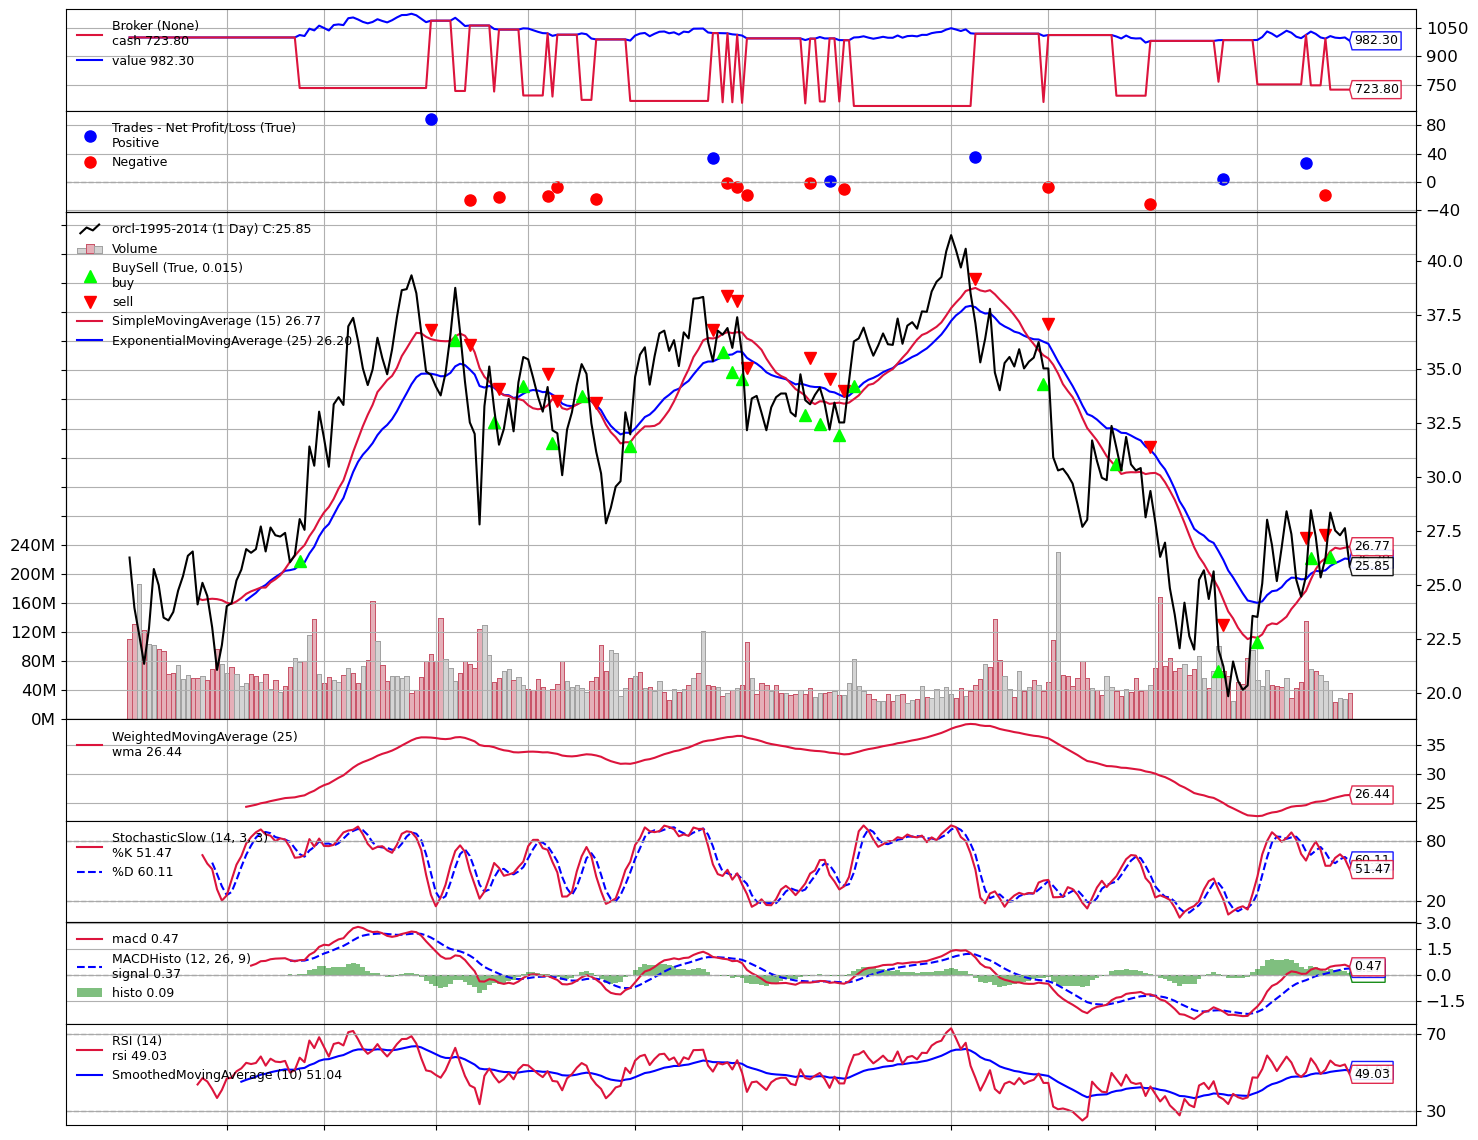

In [11]:

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = True)[0][0]

In [6]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
plt.switch_backend('Qt5Agg')

cerebro.plot(height= 30, iplot= False)


[[<Figure size 1500x940 with 8 Axes>]]

# yfinance

In [1]:
%matplotlib inline
import yfinance as yf
import pyfolio as pf

# silence warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\73915\.conda\envs\py38\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [8]:
# stock_rets = pf.utils.get_symbol_rets('APPL')
fb = yf.Ticker('APPL')
history = fb.history('max')
# history.index = history.index.tz_localize('utc')

Failed to get ticker 'APPL' reason: Expecting value: line 1 column 1 (char 0)
- APPL: No timezone found, symbol may be delisted


In [61]:
import yfinance as yf

msft = yf.Ticker("AAPL")

# get all stock info (slow)
msft.info
# fast access to subset of stock info (opportunistic)
msft.fast_info
hist = msft.history(period="1mo", proxy="http://127.0.0.1:10809")

- AAPL: No summary info found, symbol may be delisted
AAPL: No data found for this date range, symbol may be delisted
